# Data Simulation

# Import


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Settings


In [2]:
#####################

salvage_value = 0
cost = 300
price = 1000
holding_cost = 0

#####################

data_size = 300
train_size = 0.5
testing_size = 0.5
CHUNK_SIZE = data_size

T = 10
service_level = 0.95

ASSIGNED_FS = np.arange(0.1, 1.0, 0.1)
ASSIGNED_TS = list(range(2, T))  # 2 到 T-1

np.random.seed(0)

# Utils


In [3]:
# Function to replace negative values with 0
def replace_negative_with_zero(df):
    return df.applymap(lambda x: max(x, 0))

In [4]:
# Calculate service level
def calculate_service_level(*, salvage_value, cost, price):

    cu = price - cost
    co = cost - salvage_value
    service_lv = cu / (co + cu)

    return service_lv

# Generate Data


Data Shape:
1. Training data: data_size * feature_num
2. mu_matrix shape: data_size * T
3. sigma_matrix shape: data_size * T
4. corr_matrix shape: T*T
5. cov_matrices shape: data_size * T * T
6. demand_df shape: data_size * T
7. Qk_hat_df shape: data_size * T

Training Data -> Mu and Sigma -> Demand Data

## Data1: Training data


### Making full data


In [5]:
# 設定 Training data

np.random.seed(0)

full_df = pd.DataFrame(
    {
        "X1": np.random.uniform(10, 15, data_size),
        "X2": np.random.uniform(-30, -10, data_size),
        # "X3": np.random.uniform(1000, 2000, data_size),
        "X3": np.random.uniform(50, 300, data_size),
        # "X3": np.random.uniform(50, 150, data_size),
        # "X3": np.random.uniform(50, 60, data_size),
        "X4": np.random.uniform(5, 15, data_size),
    }
)

full_df

,X1,X2,X3,X4
0,12.744068,-11.868890,93.664596,13.108386
1,13.575947,-14.519053,131.997000,8.481919
2,13.013817,-23.337097,220.087167,7.114548
3,12.724416,-28.377972,65.801905,5.593832
4,12.118274,-21.855177,201.812344,13.760268
...,...,...,...,...
295,11.121585,-10.040755,174.544891,10.604506
296,10.489222,-22.756219,266.697136,11.682182
297,14.310958,-20.587021,206.933689,7.867167
298,14.864597,-22.435097,150.356987,5.194625


In [6]:
features_num = full_df.shape[1]
features_num

4

### Split training and testing data


In [8]:
def train_data_split_and_normalized_k_fold(data, train_size=0.5, chunk_size=CHUNK_SIZE):
    """
    1. 將資料切分為前半部分為訓練集，後半部分為測試集
    2. 進行標準化處理
    3. 存成 K 個 fold
    """

    folds = []
    scalers = []
    train_chunk = int(train_size * chunk_size)
    n = len(data)

    # 依序將資料切分成 chunk_size 大小的子集
    for start in range(0, n, chunk_size):
        if start + chunk_size > n:
            break  # 若剩餘資料不足一個完整的 chunk，則跳過
        chunk = data.iloc[start : start + chunk_size].reset_index(drop=True)
        train_data = chunk.iloc[:train_chunk].reset_index(drop=True)
        test_data = chunk.iloc[train_chunk:].reset_index(drop=True)

        # 建立並使用 StandardScaler 分別標準化當前的訓練與測試資料
        scaler = StandardScaler()
        train_data_normalized = scaler.fit_transform(train_data)
        test_data_normalized = scaler.transform(test_data)

        # 轉回 DataFrame 格式
        train_data_normalized = pd.DataFrame(
            train_data_normalized, columns=data.columns
        )
        test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

        folds.append((train_data_normalized, test_data_normalized))
        scalers.append(scaler)

    return folds, scalers


training_data_folds, scalers = train_data_split_and_normalized_k_fold(full_df)

for i, (train, test) in enumerate(training_data_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print("Train (normalized):")
    print(train.shape)
    print(train.head())
    print("Test (normalized):")
    print(test.shape)
    print(test.head())
    print()

Fold 1:
Train size: (150, 4), Test size: (150, 4)
Train (normalized):
(150, 4)
         X1        X2        X3        X4
0  0.137775  1.463947 -1.032261  1.083559
1  0.732660  1.014613 -0.498648 -0.481288
2  0.330675 -0.480482  0.727627 -0.943786
3  0.123722 -1.335159 -1.420129 -1.458150
4 -0.309736 -0.229223  0.473229  1.304051
Test (normalized):
(150, 4)
         X1        X2        X3        X4
0 -1.290175 -0.604554 -0.594646 -0.760536
1  1.279493  1.753727  0.272254 -1.613315
2 -1.243533 -0.764393  1.599306 -0.022770
3  0.376429 -1.251047  0.172236 -0.792732
4 -1.381811  1.614497 -0.710176  1.127121



## Data2: demand_df


由 training data -> mu and sigma matrix -> cov matrix -> multivariate normal -> demand data

### mu of each time(t)


In [9]:
# 設定由 training data 轉換到 mu matrix 的參數

b0 = 1
b1 = 4
b2 = 3
b3 = 1
b4 = -2
bt = 0


def cal_mu_matrix_with_random_noise(data_size, T, training_df, sigma_t):
    """
    1. 進行 training data 到 mu matrix 的轉換
    2. 之間的關係是線性的
    """

    np.random.seed(0)

    # 初始化 mu_matrix
    mu_matrix = np.zeros((data_size, T))

    # 生成每個 t 的隨機數
    random_noises = np.random.normal(0, sigma_t, T)

    # 計算 mu_matrix
    for t in range(1, T + 1):
        mu_matrix[:, t - 1] = (
            b0 * random_noises[t - 1]
            + b1 * training_df["X1"]
            + b2 * training_df["X2"]
            + b3 * training_df["X3"]
            + b4 * training_df["X4"]
            + bt * t
        )

    return mu_matrix

In [10]:
mu_matrix = cal_mu_matrix_with_random_noise(data_size, T, full_df, sigma_t=10)

print(f"mu_matrix shape: {mu_matrix.shape}")
print(f"mu_matrix[]:3]: \n{mu_matrix[:3]}")

mu_matrix shape: (300, 10)
mu_matrix[]:3]: 
[[100.45794754  86.81899616  92.60480392 105.22635607 101.49300398
   73.04464528  92.31830825  81.303852    81.78523556  86.9234091 ]
 [143.42031212 129.78136075 135.5671685  148.18872065 144.45536856
  116.00700986 135.28067284 124.26621658 124.74760014 129.88577368]
 [205.54257069 191.90361931 197.68942707 210.31097922 206.57762713
  178.12926843 197.40293141 186.38847515 186.86985871 192.00803225]]


### sigma matrix


In [11]:
np.random.seed(0)

# 生成輸入特徵矩陣 X (shape: data_size*feature_num)
X = full_df.values
feature_num = X.shape[1]
print(f"X.shape: {X.shape}")

# 隨機生成常數項 c 和係數向量 coefficients
c = np.random.uniform(0, 1)
coefficients = np.random.uniform(-1, 1, (feature_num, T))  # shape: (feature_num, T)

print(f"coefficients.shape: {coefficients.shape}")
print(f"coefficients: \n{coefficients}")

X.shape: (300, 4)
coefficients.shape: (4, 10)
coefficients: 
[[ 0.43037873  0.20552675  0.08976637 -0.1526904   0.29178823 -0.12482558
   0.783546    0.92732552 -0.23311696  0.58345008]
 [ 0.05778984  0.13608912  0.85119328 -0.85792788 -0.8257414  -0.95956321
   0.66523969  0.5563135   0.7400243   0.95723668]
 [ 0.59831713 -0.07704128  0.56105835 -0.76345115  0.27984204 -0.71329343
   0.88933783  0.04369664 -0.17067612 -0.47088878]
 [ 0.54846738 -0.08769934  0.1368679  -0.9624204   0.23527099  0.22419145
   0.23386799  0.88749616  0.3636406  -0.2809842 ]]


In [12]:
# 進行矩陣運算
# X.T 的形狀為 (data_size, feature_num)，X.T @ coefficients 的形狀為 (feature_num, T)
linear_combination = c + X @ coefficients

# 使用 sigmoid 函數將值映射到 [0, 1] 之間
sigma_matrix = 1 / (1 + np.exp(-linear_combination))  # shape: (data_size, T)
print(f"sigma_matrix.shape: {sigma_matrix.shape}")

# 計算每個元素的最小值和最大值
min_value = np.min(sigma_matrix)
max_value = np.max(sigma_matrix)
print(f"Value range: {(min_value, max_value)}")

# 再將值縮放到固定的的範圍

# sigma_matrix = 0 + sigma_matrix * 300

# sigma_matrix = 0 + sigma_matrix * 200
# sigma_matrix = 100 + sigma_matrix * 100
# sigma_matrix = 0 + sigma_matrix * 100
# sigma_matrix = 50 + sigma_matrix * 50
sigma_matrix = 0 + sigma_matrix * 10

# sigma_matrix = 0 + sigma_matrix * 80
# sigma_matrix = 40 + sigma_matrix * 40
# sigma_matrix = 0 + sigma_matrix * 40
# sigma_matrix = 20 + sigma_matrix * 20
# sigma_matrix = 0 + sigma_matrix * 5

# sigma_matrix = 0 + sigma_matrix * 8
# sigma_matrix = 4 + sigma_matrix * 4
# sigma_matrix = 0 + sigma_matrix * 4
# sigma_matrix = 2 + sigma_matrix * 2
# sigma_matrix = 0 + sigma_matrix * 0.3

# 計算每個元素的最小值和最大值
min_value = np.min(sigma_matrix)
max_value = np.max(sigma_matrix)
print(f"New Value range: {(min_value, max_value)}")

# 輸出 sigma_matrix 的形狀和內容
sigma_matrix_shape = sigma_matrix.shape
sigma_matrix_content = sigma_matrix

sigma_matrix_shape, sigma_matrix_content

sigma_matrix.shape: (300, 10)
Value range: (np.float64(8.503365976361974e-101), np.float64(1.0))
New Value range: (np.float64(8.503365976361974e-100), np.float64(10.0))


((300, 10),
 array([[1.00000000e+01, 1.09839831e-02, 1.00000000e+01, ...,
         1.00000000e+01, 1.82388827e-09, 6.01107974e-22],
        [1.00000000e+01, 7.12013612e-04, 1.00000000e+01, ...,
         9.99999989e+00, 5.66319701e-14, 4.10611339e-30],
        [1.00000000e+01, 2.43152722e-07, 1.00000000e+01, ...,
         9.99999826e+00, 1.69996956e-23, 9.06081076e-52],
        ...,
        [1.00000000e+01, 1.19022623e-06, 1.00000000e+01, ...,
         9.99999990e+00, 1.19344603e-21, 1.06468017e-47],
        [1.00000000e+01, 1.02466871e-04, 1.00000000e+01, ...,
         9.99997812e+00, 1.57909701e-18, 1.97484501e-36],
        [1.00000000e+01, 2.77724226e-04, 1.00000000e+01, ...,
         1.00000000e+01, 2.43398592e-14, 1.08580305e-32]]))

### corr matrix


In [13]:
# 隨機生成 correlation matrix

np.random.seed(0)

A = np.random.uniform(-1, 1, (T, T))
corr_matrix = np.dot(A, A.T)

D = np.diag(1 / np.sqrt(np.diag(corr_matrix)))
corr_matrix = D @ corr_matrix @ D

print(f"corr_matrix shape: {corr_matrix.shape}")
print(f"corr_matrix: \n{corr_matrix}")

corr_matrix shape: (10, 10)
corr_matrix: 
[[ 1.          0.35424279  0.5557836   0.58741064 -0.38777369 -0.16148427
  -0.0990728  -0.27594366 -0.48889127 -0.02092469]
 [ 0.35424279  1.          0.64567134  0.34424882 -0.53396229 -0.11871438
  -0.3666009   0.07223015  0.10995817 -0.04912633]
 [ 0.5557836   0.64567134  1.          0.259728   -0.42849166 -0.23652044
  -0.55154321  0.01056255 -0.4142461  -0.12870872]
 [ 0.58741064  0.34424882  0.259728    1.         -0.43371556 -0.07896157
   0.16623268 -0.63102156  0.08913915  0.24417687]
 [-0.38777369 -0.53396229 -0.42849166 -0.43371556  1.          0.37139904
   0.30031034  0.29401969 -0.15371929 -0.10854857]
 [-0.16148427 -0.11871438 -0.23652044 -0.07896157  0.37139904  1.
   0.65829169  0.52050763 -0.34173775  0.14741869]
 [-0.0990728  -0.3666009  -0.55154321  0.16623268  0.30031034  0.65829169
   1.          0.03894138 -0.00977194  0.48587032]
 [-0.27594366  0.07223015  0.01056255 -0.63102156  0.29401969  0.52050763
   0.03894138  1.

### cov matrix


In [14]:
# Generate covariance matrices

"""
利用公式，將 corr matrix 與 sigma_matrix 產生 cov matrix
"""

cov_matrices = []
for i in range(data_size):
    cov_matrix = np.zeros((T, T))  # 每一個模擬都會有 T*T 的共變異矩陣
    for j in range(T):
        for k in range(T):
            cov_matrix[j, k] = (
                corr_matrix[j, k] * sigma_matrix[i, j] * sigma_matrix[i, k]
            )
    cov_matrices.append(cov_matrix)

print(f"cov_matrices shape: {np.array(cov_matrices).shape}")
print(f"cov_matrices: \n{cov_matrices[0]}")

cov_matrices shape: (300, 10, 10)
cov_matrices: 
[[ 1.00000000e+02  3.89099683e-02  5.55783601e+01  1.12156325e-31
  -3.87773693e+01 -9.17704398e-23 -9.90728021e+00 -2.75943661e+01
  -8.91683058e-09 -1.25780010e-22]
 [ 3.89099683e-02  1.20647885e-04  7.09204310e-02  7.21961897e-35
  -5.86503273e-02 -7.41029942e-26 -4.02673811e-02  7.93374726e-03
   2.20285328e-12 -3.24359533e-25]
 [ 5.55783601e+01  7.09204310e-02  1.00000000e+02  4.95907562e-32
  -4.28491664e+01 -1.34412994e-22 -5.51543207e+01  1.05625460e+00
  -7.55538602e-09 -7.73678377e-22]
 [ 1.12156325e-31  7.21961897e-35  4.95907562e-32  3.64555723e-64
  -8.28107961e-32 -8.56782005e-56  3.17393738e-32 -1.20483106e-31
   3.10419274e-42  2.80245709e-54]
 [-3.87773693e+01 -5.86503273e-02 -4.28491664e+01 -8.28107961e-32
   1.00000000e+02  2.11063611e-22  3.00310341e+01  2.94019687e+01
  -2.80366805e-09 -6.52494108e-22]
 [-9.17704398e-23 -7.41029942e-26 -1.34412994e-22 -8.56782005e-56
   2.11063611e-22  3.22957346e-45  3.74102800e-22 

In [15]:
def is_positive_definite(matrix):
    """
    驗證是否為 正定矩陣, 應該要是 True
    在檢查矩陣的所有特徵值是否都大於零。當一個矩陣（通常是對稱矩陣）的所有特徵值均為正數
    """
    return np.all(np.linalg.eigvals(matrix) > 0)


positive_definite_check = all(is_positive_definite(cov) for cov in cov_matrices)
print("All covariance matrices are positive definite:", positive_definite_check)

All covariance matrices are positive definite: False


### MVN stimulation for demand_df


In [16]:
def simulate_demand_data(data_size, T, cov_matrices, mu_matrix):
    """
    利用 MVN 來模擬資料，要包含 cov_matrices 和 mu_matrix
    """

    np.random.seed(0)

    simulated_data = np.array(
        [
            np.random.multivariate_normal(mu_matrix[i], cov_matrices[i])
            for i in range(data_size)
        ]
    )

    demand_df = pd.DataFrame(
        simulated_data, columns=[f"demand_t{t}" for t in range(1, T + 1)]
    )
    return demand_df


demand_df = simulate_demand_data(data_size, T, cov_matrices, mu_matrix)
demand_df

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,91.916457,86.803323,70.555039,105.226356,125.384355,73.044645,91.422994,75.835748,81.785236,86.923409
1,143.573192,129.780764,126.171244,148.188721,141.918646,116.007010,138.759426,110.370549,124.747600,129.885774
2,225.200094,191.903620,206.421002,210.310979,179.706716,178.129268,177.857273,173.738120,186.869859,192.008032
3,38.601778,24.385985,28.533018,42.786920,28.955408,10.605209,42.431887,25.660290,19.345799,24.483973
4,190.079285,161.200945,188.328408,179.608305,186.257503,147.426594,158.178135,163.833001,156.167184,161.305358
...,...,...,...,...,...,...,...,...,...,...
295,196.587240,171.701543,193.255966,190.108887,180.872757,157.927177,171.225912,158.053017,166.667767,171.805940
296,245.311939,221.022577,234.774085,239.429936,226.627119,207.248226,218.061579,205.097288,215.988816,221.126989
297,210.659779,190.683694,205.372748,209.091055,197.177131,176.909344,189.272553,187.617323,185.649934,190.788108
298,165.256110,136.122475,144.981844,154.529770,143.582843,122.348059,156.805504,134.252943,131.088650,136.226823


### Replace negative values to 0


In [17]:
"""
這裡是為了讓 demand data 中的數值不能小於 0，才特別做的處理
"""

demand_df = replace_negative_with_zero(demand_df)
demand_df

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_96164/2799096767.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: max(x, 0))


,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,91.916457,86.803323,70.555039,105.226356,125.384355,73.044645,91.422994,75.835748,81.785236,86.923409
1,143.573192,129.780764,126.171244,148.188721,141.918646,116.007010,138.759426,110.370549,124.747600,129.885774
2,225.200094,191.903620,206.421002,210.310979,179.706716,178.129268,177.857273,173.738120,186.869859,192.008032
3,38.601778,24.385985,28.533018,42.786920,28.955408,10.605209,42.431887,25.660290,19.345799,24.483973
4,190.079285,161.200945,188.328408,179.608305,186.257503,147.426594,158.178135,163.833001,156.167184,161.305358
...,...,...,...,...,...,...,...,...,...,...
295,196.587240,171.701543,193.255966,190.108887,180.872757,157.927177,171.225912,158.053017,166.667767,171.805940
296,245.311939,221.022577,234.774085,239.429936,226.627119,207.248226,218.061579,205.097288,215.988816,221.126989
297,210.659779,190.683694,205.372748,209.091055,197.177131,176.909344,189.272553,187.617323,185.649934,190.788108
298,165.256110,136.122475,144.981844,154.529770,143.582843,122.348059,156.805504,134.252943,131.088650,136.226823


### Validate the mean and std of total demand


In [18]:
def check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix):
    """
    檢查生成的需求數據是否符合上述總需求的特性。例如，從生成的需求 demand_df 中計算總需求
    𝐷，然後檢查其均值和標準差是否接近理論值（即均值為所有
    𝜇𝑡 的和，標準差根據共變異數矩陣計算）。
    """

    results = []
    for i in range(len(demand_df)):

        demand_i = demand_df.iloc[i, :]

        # theoretical mean
        theoretical_mean = mu_matrix[i].sum()

        # theoretical std
        variance_sum = np.sum(np.diag(cov_matrices[i]))
        covariance_sum = np.sum(cov_matrices[i]) - variance_sum
        theoretical_variance = variance_sum + covariance_sum
        theoretical_std = np.sqrt(theoretical_variance)

        # empirical mean and std
        empirical_mean = demand_i.sum()
        empirical_std = demand_i.std(ddof=0)  # 指定除以 n 而非 n-1
        std_relative_error = abs(theoretical_std - empirical_std) / empirical_std * 100

        # save the results
        results.append(
            {
                "theoretical_mean": theoretical_mean,
                "empirical_mean": empirical_mean,
                "theoretical_std": theoretical_std,
                "empirical_std": empirical_std,
                "std_relative_error": std_relative_error,  # 百分比
            }
        )

    return pd.DataFrame(results)


results_df = check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix)
results_df

,theoretical_mean,empirical_mean,theoretical_std,empirical_std,std_relative_error
0,901.976558,888.897561,19.783739,15.590538,26.895801
1,1331.600204,1309.402926,19.782845,11.612186,70.362802
2,1952.822789,1922.144962,19.782782,15.963728,23.923322
3,277.582196,285.790268,19.719341,9.723919,102.792115
4,1645.796045,1692.384719,19.782783,14.565881,35.815906
...,...,...,...,...,...
295,1750.801870,1758.206207,19.782785,13.186190,50.026547
296,2244.012362,2234.688553,19.782783,12.517751,58.037843
297,1940.623544,1943.221669,19.782783,10.439825,89.493443
298,1395.010700,1425.195022,19.782780,12.485555,58.445345


### Validate normal distribution


In [19]:
demand_df

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,91.916457,86.803323,70.555039,105.226356,125.384355,73.044645,91.422994,75.835748,81.785236,86.923409
1,143.573192,129.780764,126.171244,148.188721,141.918646,116.007010,138.759426,110.370549,124.747600,129.885774
2,225.200094,191.903620,206.421002,210.310979,179.706716,178.129268,177.857273,173.738120,186.869859,192.008032
3,38.601778,24.385985,28.533018,42.786920,28.955408,10.605209,42.431887,25.660290,19.345799,24.483973
4,190.079285,161.200945,188.328408,179.608305,186.257503,147.426594,158.178135,163.833001,156.167184,161.305358
...,...,...,...,...,...,...,...,...,...,...
295,196.587240,171.701543,193.255966,190.108887,180.872757,157.927177,171.225912,158.053017,166.667767,171.805940
296,245.311939,221.022577,234.774085,239.429936,226.627119,207.248226,218.061579,205.097288,215.988816,221.126989
297,210.659779,190.683694,205.372748,209.091055,197.177131,176.909344,189.272553,187.617323,185.649934,190.788108
298,165.256110,136.122475,144.981844,154.529770,143.582843,122.348059,156.805504,134.252943,131.088650,136.226823


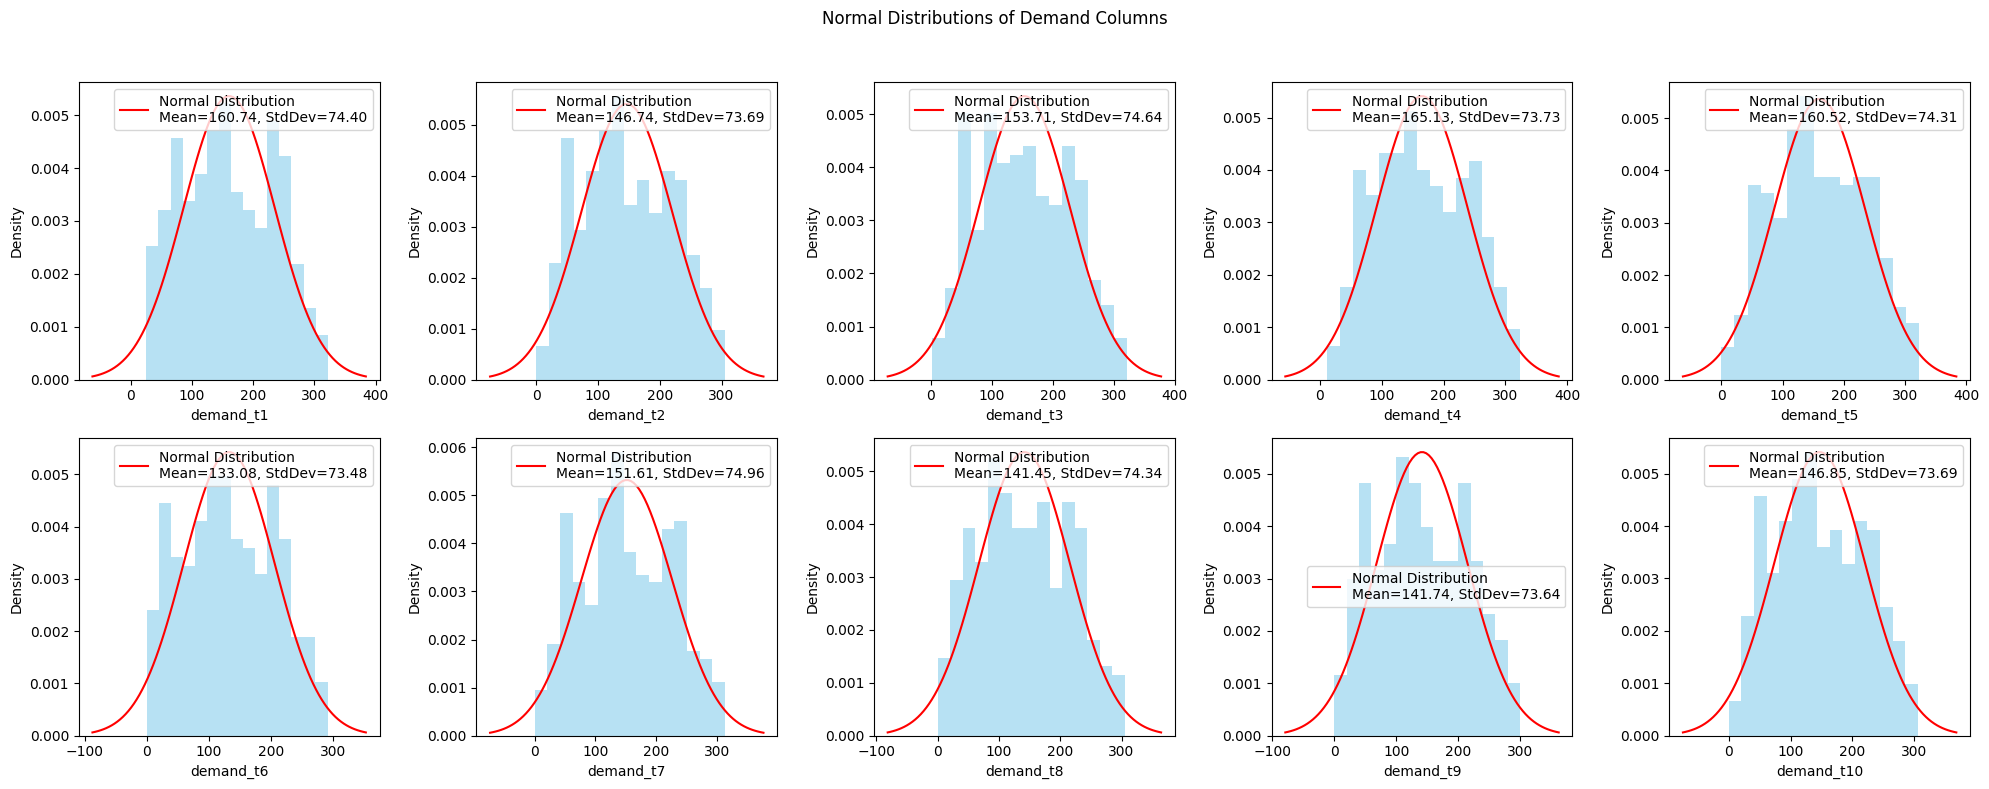

In [20]:
"""
1. 檢查每一個 T 的分佈是否為 Normal
2. 紅線為理論值
"""

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Normal Distributions of Demand Columns")

for idx, column in enumerate(demand_df.columns):
    data = demand_df[column].dropna()  # 移除缺失值
    mean, std_dev = np.mean(data), np.std(data)

    # 產生 x 值範圍
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
    pdf = norm.pdf(x, mean, std_dev)

    # 確定當前的軸位置
    ax = axes[idx // 5, idx % 5]
    ax.hist(data, bins=15, density=True, alpha=0.6, color="skyblue")
    ax.plot(
        x,
        pdf,
        "r-",
        label=f"Normal Distribution\nMean={mean:.2f}, StdDev={std_dev:.2f}",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# 移除空白子圖（若有）
for idx in range(len(demand_df.columns), 10):
    fig.delaxes(axes[idx // 5, idx % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Validate the covariance


In [21]:
demand_df.cov()

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,5554.364821,5453.893364,5526.459849,5456.922000,5414.679107,5439.019190,5484.824804,5430.883964,5450.250086,5453.988734
demand_t2,5453.893364,5448.104172,5471.797629,5451.406892,5445.645464,5431.799104,5490.823101,5453.040215,5444.141935,5448.222074
demand_t3,5526.459849,5471.797629,5590.252348,5475.168262,5427.326368,5455.142043,5456.738915,5478.989614,5467.691826,5471.894653
demand_t4,5456.922000,5451.406892,5475.168262,5454.854838,5449.287375,5434.799934,5494.229886,5456.214336,5447.334646,5451.527397
demand_t5,5414.679107,5445.645464,5427.326368,5449.287375,5539.874894,5428.418603,5519.864204,5475.940357,5441.506140,5445.803585
demand_t6,5439.019190,5431.799104,5455.142043,5434.799934,5428.418603,5416.730315,5474.186137,5437.008157,5428.193657,5431.911613
demand_t7,5484.824804,5490.823101,5456.738915,5494.229886,5519.864204,5474.186137,5637.793139,5501.544377,5486.726830,5490.952111
demand_t8,5430.883964,5453.040215,5478.989614,5456.214336,5475.940357,5437.008157,5501.544377,5545.531719,5449.192531,5453.144343
demand_t9,5450.250086,5444.141935,5467.691826,5447.334646,5441.506140,5428.193657,5486.726830,5449.192531,5440.298740,5444.258488
demand_t10,5453.988734,5448.222074,5471.894653,5451.527397,5445.803585,5431.911613,5490.952111,5453.144343,5444.258488,5448.340327


In [22]:
empirical_covariance = demand_df.cov()
covariance_diff = np.abs(empirical_covariance - np.array(cov_matrices).mean(axis=0))
covariance_diff

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,5454.364821,5453.867808,5470.881634,5456.922000,5453.456476,5439.019280,5494.732084,5458.476073,5450.250086,5453.988734
demand_t2,5453.867808,5448.103398,5471.751049,5451.406892,5445.683986,5431.799104,5490.849549,5453.035005,5444.141935,5448.222074
demand_t3,5470.881634,5471.751049,5490.252870,5475.168262,5470.175423,5455.142175,5511.893092,5477.933448,5467.691826,5471.894653
demand_t4,5456.922000,5451.406892,5475.168262,5454.854838,5449.287375,5434.799934,5494.229886,5456.214336,5447.334646,5451.527397
demand_t5,5453.456476,5445.683986,5470.175423,5449.287375,5439.874894,5428.418395,5489.833170,5446.540793,5441.506140,5445.803585
demand_t6,5439.019280,5431.799104,5455.142175,5434.799934,5428.418395,5416.730314,5474.185769,5437.007866,5428.193657,5431.911613
demand_t7,5494.732084,5490.849549,5511.893092,5494.229886,5489.833170,5474.185769,5537.793139,5497.650558,5486.726830,5490.952111
demand_t8,5458.476073,5453.035005,5477.933448,5456.214336,5446.540793,5437.007866,5497.650558,5445.548024,5449.192531,5453.144343
demand_t9,5450.250086,5444.141935,5467.691826,5447.334646,5441.506140,5428.193657,5486.726830,5449.192531,5440.298740,5444.258488
demand_t10,5453.988734,5448.222074,5471.894653,5451.527397,5445.803585,5431.911613,5490.952111,5453.144343,5444.258488,5448.340327


### Validate the corr matrix of damand_df is close to original setting


要驗證實際生成出來的 demand data 的 corr 應該要跟當初生成時的理論值 corr 相近
。因為我們過程中有加入一些噪音，以及非線性處理（將負值替代為 0），
因此兩者要相近，才代表沒有差距太多，才能讓實際的 demand 與理論設計的資料相似。

In [23]:
correlation_matrix = demand_df.corr()
print("Correlation Matrix from demand_df:")
correlation_matrix

Correlation Matrix from demand_df:


,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
demand_t1,1.000000,0.991441,0.991777,0.991377,0.976125,0.991596,0.980146,0.978547,0.991489,0.991437
demand_t2,0.991441,1.000000,0.991497,0.999987,0.991235,0.999890,0.990741,0.992075,0.999989,1.000000
demand_t3,0.991777,0.991497,1.000000,0.991494,0.975260,0.991338,0.971992,0.984041,0.991464,0.991494
demand_t4,0.991377,0.999987,0.991494,1.000000,0.991284,0.999824,0.990742,0.992038,0.999956,0.999987
demand_t5,0.976125,0.991235,0.975260,0.991284,1.000000,0.990957,0.987697,0.987955,0.991192,0.991242
demand_t6,0.991596,0.999890,0.991338,0.999824,0.990957,1.000000,0.990596,0.992019,0.999943,0.999889
demand_t7,0.980146,0.990741,0.971992,0.990742,0.987697,0.990596,1.000000,0.983917,0.990712,0.990743
demand_t8,0.978547,0.992075,0.984041,0.992038,0.987955,0.992019,0.983917,1.000000,0.992086,0.992072
demand_t9,0.991489,0.999989,0.991464,0.999956,0.991192,0.999943,0.990712,0.992086,1.000000,0.999989
demand_t10,0.991437,1.000000,0.991494,0.999987,0.991242,0.999889,0.990743,0.992072,0.999989,1.000000


In [24]:
print(f"Original corr_matrix shape: {corr_matrix.shape}")
corr_matrix_df = pd.DataFrame(corr_matrix)
corr_matrix_df

Original corr_matrix shape: (10, 10)


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.354243,0.555784,0.587411,-0.387774,-0.161484,-0.099073,-0.275944,-0.488891,-0.020925
1,0.354243,1.000000,0.645671,0.344249,-0.533962,-0.118714,-0.366601,0.072230,0.109958,-0.049126
2,0.555784,0.645671,1.000000,0.259728,-0.428492,-0.236520,-0.551543,0.010563,-0.414246,-0.128709
3,0.587411,0.344249,0.259728,1.000000,-0.433716,-0.078962,0.166233,-0.631022,0.089139,0.244177
4,-0.387774,-0.533962,-0.428492,-0.433716,1.000000,0.371399,0.300310,0.294020,-0.153719,-0.108549
5,-0.161484,-0.118714,-0.236520,-0.078962,0.371399,1.000000,0.658292,0.520508,-0.341738,0.147419
6,-0.099073,-0.366601,-0.551543,0.166233,0.300310,0.658292,1.000000,0.038941,-0.009772,0.485870
7,-0.275944,0.072230,0.010563,-0.631022,0.294020,0.520508,0.038941,1.000000,-0.203659,0.130487
8,-0.488891,0.109958,-0.414246,0.089139,-0.153719,-0.341738,-0.009772,-0.203659,1.000000,0.355112
9,-0.020925,-0.049126,-0.128709,0.244177,-0.108549,0.147419,0.485870,0.130487,0.355112,1.000000


### Split test and train demand_df


In [25]:
def demand_data_split_data_k_fold(data):
    """
    1. 對 demand data 切資料
    2. 以 0.5 為訓練與測試的比例
    3. chunk 代表每一個 fold 包含訓練與測試數據的數量為多少
    4. 共有 data/ chunk = k fold 的資料
    """

    folds = []
    chunk_size = CHUNK_SIZE  # 每組的訓練與測試數據共包含多少資料
    train_chunk = int(train_size * chunk_size)

    n = len(data)
    # 依序切分每一個 chunk
    for start in range(0, n, chunk_size):
        # 若剩餘資料不足 60 筆，這裡直接跳過
        if start + chunk_size > n:
            break
        chunk = data.iloc[start : start + chunk_size].reset_index(drop=True)
        train_data = chunk.iloc[:train_chunk].reset_index(drop=True)
        test_data = chunk.iloc[train_chunk:].reset_index(drop=True)
        folds.append((train_data, test_data))

    return folds


# 使用函數切分資料
demand_folds = demand_data_split_data_k_fold(demand_df)

# 印出結果，每個 fold 的訓練與測試資料
for i, (train_data, test_data) in enumerate(demand_folds, 1):
    print(f"Fold {i}:")
    print("Train Data:")
    print(train_data.shape)
    print("Test Data:")
    print(test_data.shape)
    print("=" * 40)

Fold 1:
Train Data:
(150, 10)
Test Data:
(150, 10)


### Define the Q star(Q optimal)


In [26]:
def calculate_Q_star(demand_df, service_level=0.95):
    """
    1. 設定一個 Q star 來估計期初進貨量
    """

    # 計算每一行的總和
    demand_sum = demand_df.sum(axis=1)

    # 計算總和的均值和標準差
    mean_sum = demand_sum.mean()
    std_sum = demand_sum.std()

    # 計算總和的95%百分位數值
    Q_star = norm.ppf(service_level, loc=mean_sum, scale=std_sum)

    # 打印結果
    print(f"mean of sum: {mean_sum}")
    print(f"std of sum: {std_sum}")
    print(f"{service_level*100} percentile of sum: {Q_star}")

    return Q_star

In [27]:
# 用其中一個 fold 來計算 Q star
demand_df_train_1 = demand_folds[0][0]
Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
print(f"Q_star: {Q_star}\n")

mean of sum: 1439.8320761161826
std of sum: 752.2221842165333
95.0 percentile of sum: 2677.1274640981055
Q_star: 2677.1274640981055



## Data3: Qk hat df


1. 計算目前在 k 時期，代表經過 k-1 個時期後，我用 1~k-1 的真實數據去對我未來 k~T 的需求量進行重新估計
2. Qk 的 k 有 2~9。 3 代表在 T=3 時，我用 T=1,2 的真實數據，對 T=3~9 數據重新估計。
3. 公式連結：https://jujueffectivelife.notion.site/Qk-eab4d89ec36345efbf3a0d4a4f488474?pvs=4
4. 有用 R code 進行驗證，方法在 python 是可行的。
5. 用 conditional distribution 來重新估計 mu, sigma, 然後再用 MVN 估計一次需求


### Functions


In [ ]:
# 計算條件分佈的函數
def calculate_conditional_distribution(mu, covariance_matrix, x_observed, k):

    mu_1 = mu[:k] # 之前
    mu_2 = mu[k:] # 之後
    Sigma_11 = covariance_matrix[:k, :k]
    Sigma_22 = covariance_matrix[k:, k:]
    Sigma_12 = covariance_matrix[k:, :k]
    Sigma_21 = covariance_matrix[:k, k:]

    # Compute conditional mean and covariance
    Sigma_11_inv = np.linalg.pinv(Sigma_11)
    mu_cond = mu_2 + np.dot(Sigma_12, np.dot(Sigma_11_inv, (x_observed - mu_1)))
    sigma_cond = Sigma_22 - np.dot(Sigma_12, np.dot(Sigma_11_inv, Sigma_21))

    return mu_cond, sigma_cond

In [29]:
def cal_Var_Y(sigma_cond):

    # Extract the variances (diagonal elements)
    variances = np.diag(sigma_cond)

    # Calculate the sum of covariances (off-diagonal elements)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)

    # Total variance for the sum of mu_cond
    total_variance = np.sum(variances) + covariances_sum

    return total_variance

In [30]:
def cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed):
    # predict_quantity = mu_cond + norm.ppf(service_level) * np.sqrt(np.diag(sigma_cond))
    # Qk_hat = x_observed.sum() + predict_quantity.sum()

    mean_Y = np.sum(mu_cond)
    var_Y = cal_Var_Y(sigma_cond)

    sd_Y = np.sqrt(var_Y)
    if sd_Y < 0 or np.isnan(sd_Y):  # scale must be positive
        sd_Y = 1e-6

    percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=sd_Y)

    # print(f"        mean_Y: {mean_Y}")
    # print(f"        sd_Y: {sd_Y}")
    # print(f"    percentile_95_Y: {percentile_95_Y}")

    Qk_hat = x_observed.sum() + percentile_95_Y
    return Qk_hat

In [31]:
def cal_mu_and_cov_matrix(demand_df_train):

    mu_matrix = demand_df_train.mean().values
    covariance_matrix = demand_df_train.cov().values

    # print(f"mu_matrix: {mu_matrix}")
    # print(f"covariance_matrix: \n{covariance_matrix}\n")

    return mu_matrix, covariance_matrix

In [32]:
def make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix):
    results_df = pd.DataFrame(index=demand_df.index)

    for index, row_data in demand_df.iterrows():
        for k in range(2, T):
            # print(f"Now processing index: {index}, t={k}")

            x_observed = row_data[
                : k - 1
            ].values  # 取出前 k 個觀測值 -> Qk_hat_2(t=2): 則 observerd: T=1

            mu_cond, sigma_cond = calculate_conditional_distribution(
                mu_matrix, covariance_matrix, x_observed, len(x_observed)
            )

            Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)

            results_df.loc[index, f"Qk_hat_k{k}"] = Qk_hat

            # print(f"    x_observed: {x_observed}")
            # print(f"    mu_cond: {mu_cond}")
            # print(f"    sigma_cond: \n{sigma_cond}")
            # print(f"    Qk_hat: {Qk_hat}")
            # print("\n")

    return results_df

### Validate the consistency of condMVN in Python and R


#### Given mu and sigma


In [33]:
from scipy.stats import multivariate_normal

# Define the mean vector and the covariance matrix
mu = np.array([10, 20, 30, 40])
covariance_matrix = np.array([[5, 1, 0, 2], [1, 8, 1, 0], [0, 1, 10, 1], [2, 0, 1, 7]])

# Mean and covariance partitioning
mu_1 = mu[:2]
mu_2 = mu[2:]
Sigma_11 = covariance_matrix[:2, :2]
Sigma_22 = covariance_matrix[2:, 2:]
Sigma_12 = covariance_matrix[2:, :2]
Sigma_21 = covariance_matrix[:2, 2:]

print(f"Sigma_11: \n{Sigma_11}\n")
print(f"Sigma_22: \n{Sigma_22}\n")
print(f"Sigma_12: \n{Sigma_12}\n")
print(f"Sigma_21: \n{Sigma_21}\n")

Sigma_11: 
[[5 1]
 [1 8]]

Sigma_22: 
[[10  1]
 [ 1  7]]

Sigma_12: 
[[0 1]
 [2 0]]

Sigma_21: 
[[0 2]
 [1 0]]



In [34]:
# Observed values of X1 and X2
x_observed = np.array([6, 30])

mu_cond, sigma_cond = calculate_conditional_distribution(
    mu, covariance_matrix, x_observed, len(x_observed)
)
print(f"mu_cond: {mu_cond}")
print(f"sigma_cond: \n{sigma_cond}")

mu_cond: [31.38461538 37.84615385]
sigma_cond: 
[[9.87179487 1.05128205]
 [1.05128205 6.17948718]]


In [35]:
# Define the conditional distribution
conditional_dist = multivariate_normal(mean=mu_cond, cov=sigma_cond)

# Values at which to evaluate the PDF and CDF
x3, x4 = 30, 40  # These can be any values of interest

# Calculate the PDF
pdf_value = conditional_dist.pdf([x3, x4])
print(f"Conditional density at X3 = {x3}, X4 = {x4}: {pdf_value}")

# Calculate the CDF
cdf_value = conditional_dist.cdf([x3, x4])
print(f"Conditional cumulative probability up to X3 = {x3}, X4 = {x4}: {cdf_value}")

# Qk hat
Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)
print(f"Qk_hat of x_observed: {Qk_hat}")

Conditional density at X3 = 30, X4 = 40: 0.012061749355189695
Conditional cumulative probability up to X3 = 30, X4 = 40: 0.2790601403798458
Qk_hat of x_observed: 112.23905144741786


```
R 中運行的結果
```

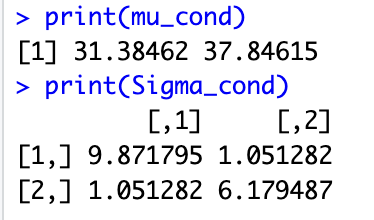
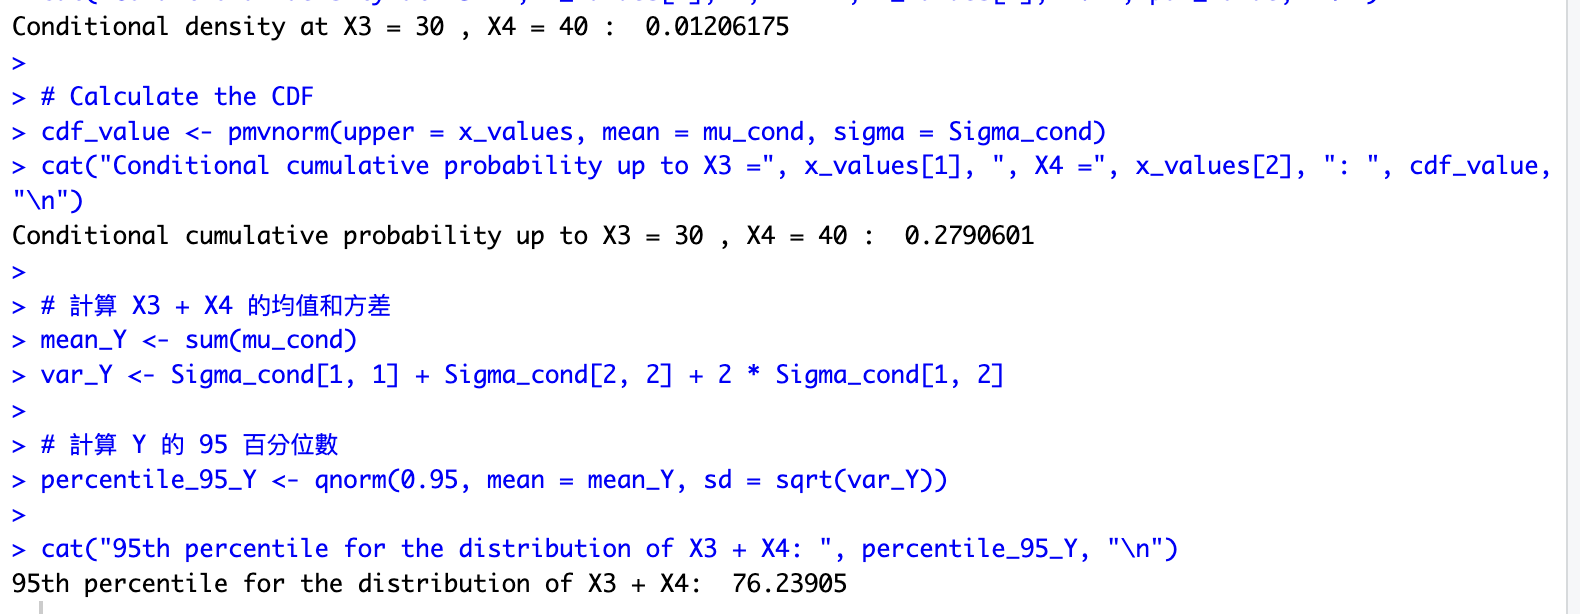


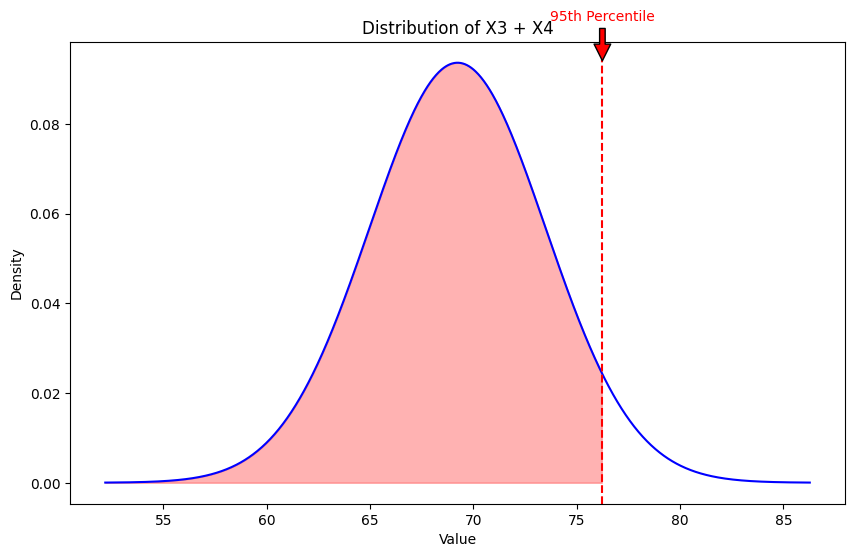

In [36]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean_Y = np.sum(mu_cond)
var_Y = cal_Var_Y(sigma_cond)

percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=np.sqrt(var_Y))

# Generate normal distribution data
x_values = np.linspace(mean_Y - 4 * np.sqrt(var_Y), mean_Y + 4 * np.sqrt(var_Y), 1000)
y_values = norm.pdf(x_values, loc=mean_Y, scale=np.sqrt(var_Y))

# Create dataframe
data = pd.DataFrame({"x": x_values, "y": y_values})

# Plot distribution
plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["y"], color="blue")
plt.axvline(x=percentile_95_Y, color="red", linestyle="dashed")
plt.fill_between(
    data["x"], data["y"], where=(data["x"] <= percentile_95_Y), color="red", alpha=0.3
)
plt.title("Distribution of X3 + X4")
plt.xlabel("Value")
plt.ylabel("Density")
plt.annotate(
    "95th Percentile",
    xy=(percentile_95_Y, max(y_values)),
    xytext=(percentile_95_Y, max(y_values) * 1.1),
    arrowprops=dict(facecolor="red", shrink=0.05),
    color="red",
    ha="center",
)
plt.show()

```
以下為 R 程式結果
```


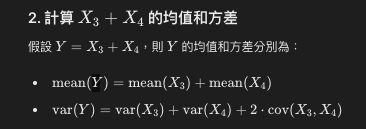


P(X3,X4∣X1=10,X2=20) 的 R 計算如下

```
install.packages("condMVNorm")
install.packages("mvtnorm")
library(condMVNorm)
library(mvtnorm)
library(ggplot2)

# Define the mean vector and covariance matrix
mu <- c(10, 20, 30, 40)
sigma <- matrix(c(
    5, 1, 0, 2,
    1, 8, 1, 0,
    0, 1, 10, 1,
    2, 0, 1, 7
), nrow = 4, byrow = TRUE)

# Observed values of X1 and X2
x_observed <- c(6, 30)

# Compute the conditional mean and covariance using condMVNorm
conditional_results <- condMVN(mean = mu, sigma = sigma, dependent.ind = c(3, 4), given.ind = c(1, 2), X.given = x_observed)

# Print the conditional mean and covariance
print(conditional_results$condMean)
print(conditional_results$condVar)

# Extract the conditional mean and covariance
mu_cond <- conditional_results$condMean
Sigma_cond <- conditional_results$condVar

# Print the conditional mean and covariance
print(mu_cond)
print(Sigma_cond)

# Values at which to evaluate the PDF and CDF
x_values <- c(30, 40)

# Calculate the PDF
pdf_value <- dmvnorm(x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional density at X3 =", x_values[1], ", X4 =", x_values[2], ": ", pdf_value, "\n")

# Calculate the CDF
cdf_value <- pmvnorm(upper = x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional cumulative probability up to X3 =", x_values[1], ", X4 =", x_values[2], ": ", cdf_value, "\n")

```


#### Conditional mean and variance


In [37]:
def cal_Var_Y(sigma_cond):
    variances = np.diag(sigma_cond)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)
    total_variance = np.sum(variances) + covariances_sum

    return total_variance


def simulate_Y(mu_cond, sigma_cond, num_samples=10000):
    samples = np.random.multivariate_normal(mu_cond, sigma_cond, num_samples)

    Y = samples[:, 0] + samples[:, 1]

    mean_Y = np.mean(Y)
    var_Y = np.var(Y)

    return mean_Y, var_Y


mu_cond = [2, 3]
sigma_cond = [[1, 0.5], [0.5, 1]]

mean_Y_formula = np.sum(mu_cond)
var_Y_formula = cal_Var_Y(sigma_cond)

mean_Y_simulated, var_Y_simulated = simulate_Y(mu_cond, sigma_cond)

print(f"公式計算的Y的均值: {mean_Y_formula}")
print(f"公式計算的Y的方差: {var_Y_formula}")
print(f"模擬計算的Y的均值: {mean_Y_simulated}")
print(f"模擬計算的Y的方差: {var_Y_simulated}")

公式計算的Y的均值: 5
公式計算的Y的方差: 3.0
模擬計算的Y的均值: 5.007898249514813
模擬計算的Y的方差: 2.98385448769945


### Calculate Qk hat for 2~T-1 of demand_df_train


In [38]:
demand_df_train = demand_folds[0][0]

In [39]:
_, _ = cal_mu_and_cov_matrix(demand_df_train)

In [40]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df)
Qk_hat_df = make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix)

In [45]:
demand_df.head()

,demand_t1,demand_t2,demand_t3,demand_t4,demand_t5,demand_t6,demand_t7,demand_t8,demand_t9,demand_t10
0,91.916457,86.803323,70.555039,105.226356,125.384355,73.044645,91.422994,75.835748,81.785236,86.923409
1,143.573192,129.780764,126.171244,148.188721,141.918646,116.007010,138.759426,110.370549,124.747600,129.885774
2,225.200094,191.903620,206.421002,210.310979,179.706716,178.129268,177.857273,173.738120,186.869859,192.008032
3,38.601778,24.385985,28.533018,42.786920,28.955408,10.605209,42.431887,25.660290,19.345799,24.483973
4,190.079285,161.200945,188.328408,179.608305,186.257503,147.426594,158.178135,163.833001,156.167184,161.305358


In [46]:
Qk_hat_df.head()

,Qk_hat_k2,Qk_hat_k3,Qk_hat_k4,Qk_hat_k5,Qk_hat_k6,Qk_hat_k7,Qk_hat_k8,Qk_hat_k9
0,974.222334,923.859370,921.119447,921.106225,934.190402,933.867126,906.473190,889.077157
1,1482.620732,1360.332810,1358.753593,1358.745383,1343.291786,1342.958605,1332.041017,1309.562579
2,2285.981350,1996.276101,1995.832972,1995.825210,1960.507112,1960.141761,1932.996312,1922.277683
3,449.506678,305.653347,305.226321,305.213428,282.954046,282.421917,291.200375,285.913403
4,1940.327232,1685.752362,1687.487189,1687.484216,1709.122738,1709.002750,1702.326690,1692.557697


### Plot the distribuction


1. 對 Qk hat 不同估計時期（早期、中期、晚期）進行分布圖分析
2. 與 Q star 進行比較 -> 越晚期應該要離 Q star 越遠

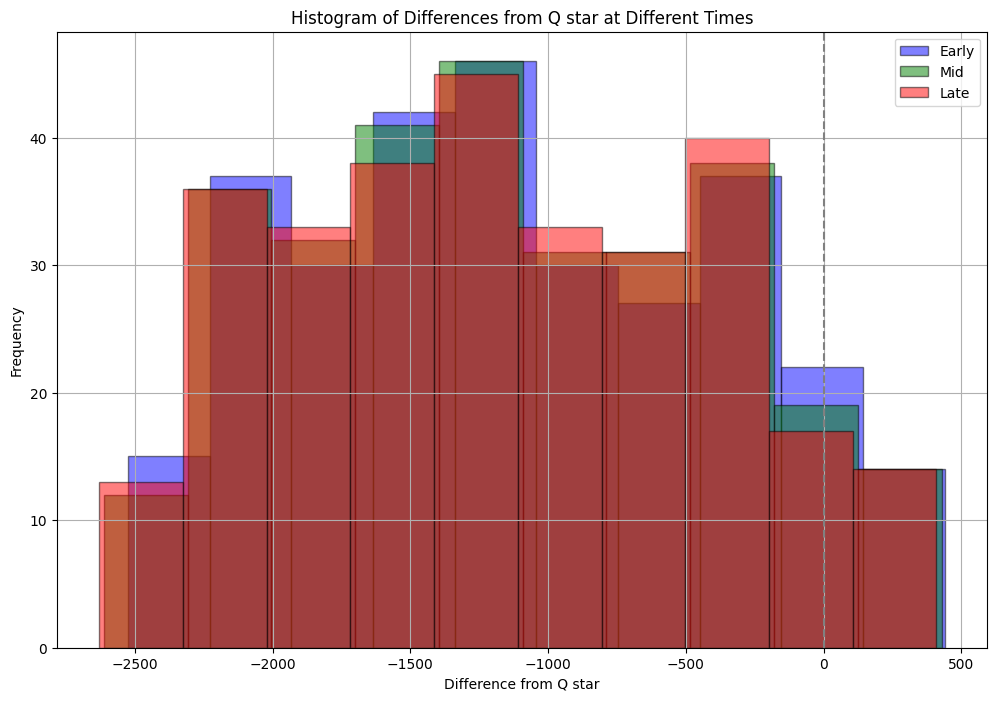

Q_star is: 2677.1274640981055
Early bias: -1106.4640099343299
Mid bias: -1152.3027745764127
Late bias: -1168.8046964246678


In [42]:
# 將 T 個時期分成三份
early_values = Qk_hat_df.iloc[:, : T // 3].mean(axis=1)
mid_values = Qk_hat_df.iloc[:, T // 3 : 2 * T // 3].mean(axis=1)
late_values = Qk_hat_df.iloc[:, 2 * T // 3 :].mean(axis=1)

# 計算與 Q_star 的差距
early_diff = early_values - Q_star
mid_diff = mid_values - Q_star
late_diff = late_values - Q_star

# 繪製直方圖
plt.figure(figsize=(12, 8))

# 早期
plt.hist(early_diff, bins=10, alpha=0.5, label="Early", color="blue", edgecolor="black")
# 中期
plt.hist(mid_diff, bins=10, alpha=0.5, label="Mid", color="green", edgecolor="black")
# 晚期
plt.hist(late_diff, bins=10, alpha=0.5, label="Late", color="red", edgecolor="black")

plt.axvline(0, color="grey", linestyle="--")

plt.xlabel("Difference from Q star")
plt.ylabel("Frequency")
plt.title("Histogram of Differences from Q star at Different Times")
plt.legend()
plt.grid(True)
plt.show()

# 計算偏差
early_bias = np.mean(early_diff)
mid_bias = np.mean(mid_diff)
late_bias = np.mean(late_diff)

print(f"Q_star is: {Q_star}")
print(f"Early bias: {early_bias}")
print(f"Mid bias: {mid_bias}")
print(f"Late bias: {late_bias}")

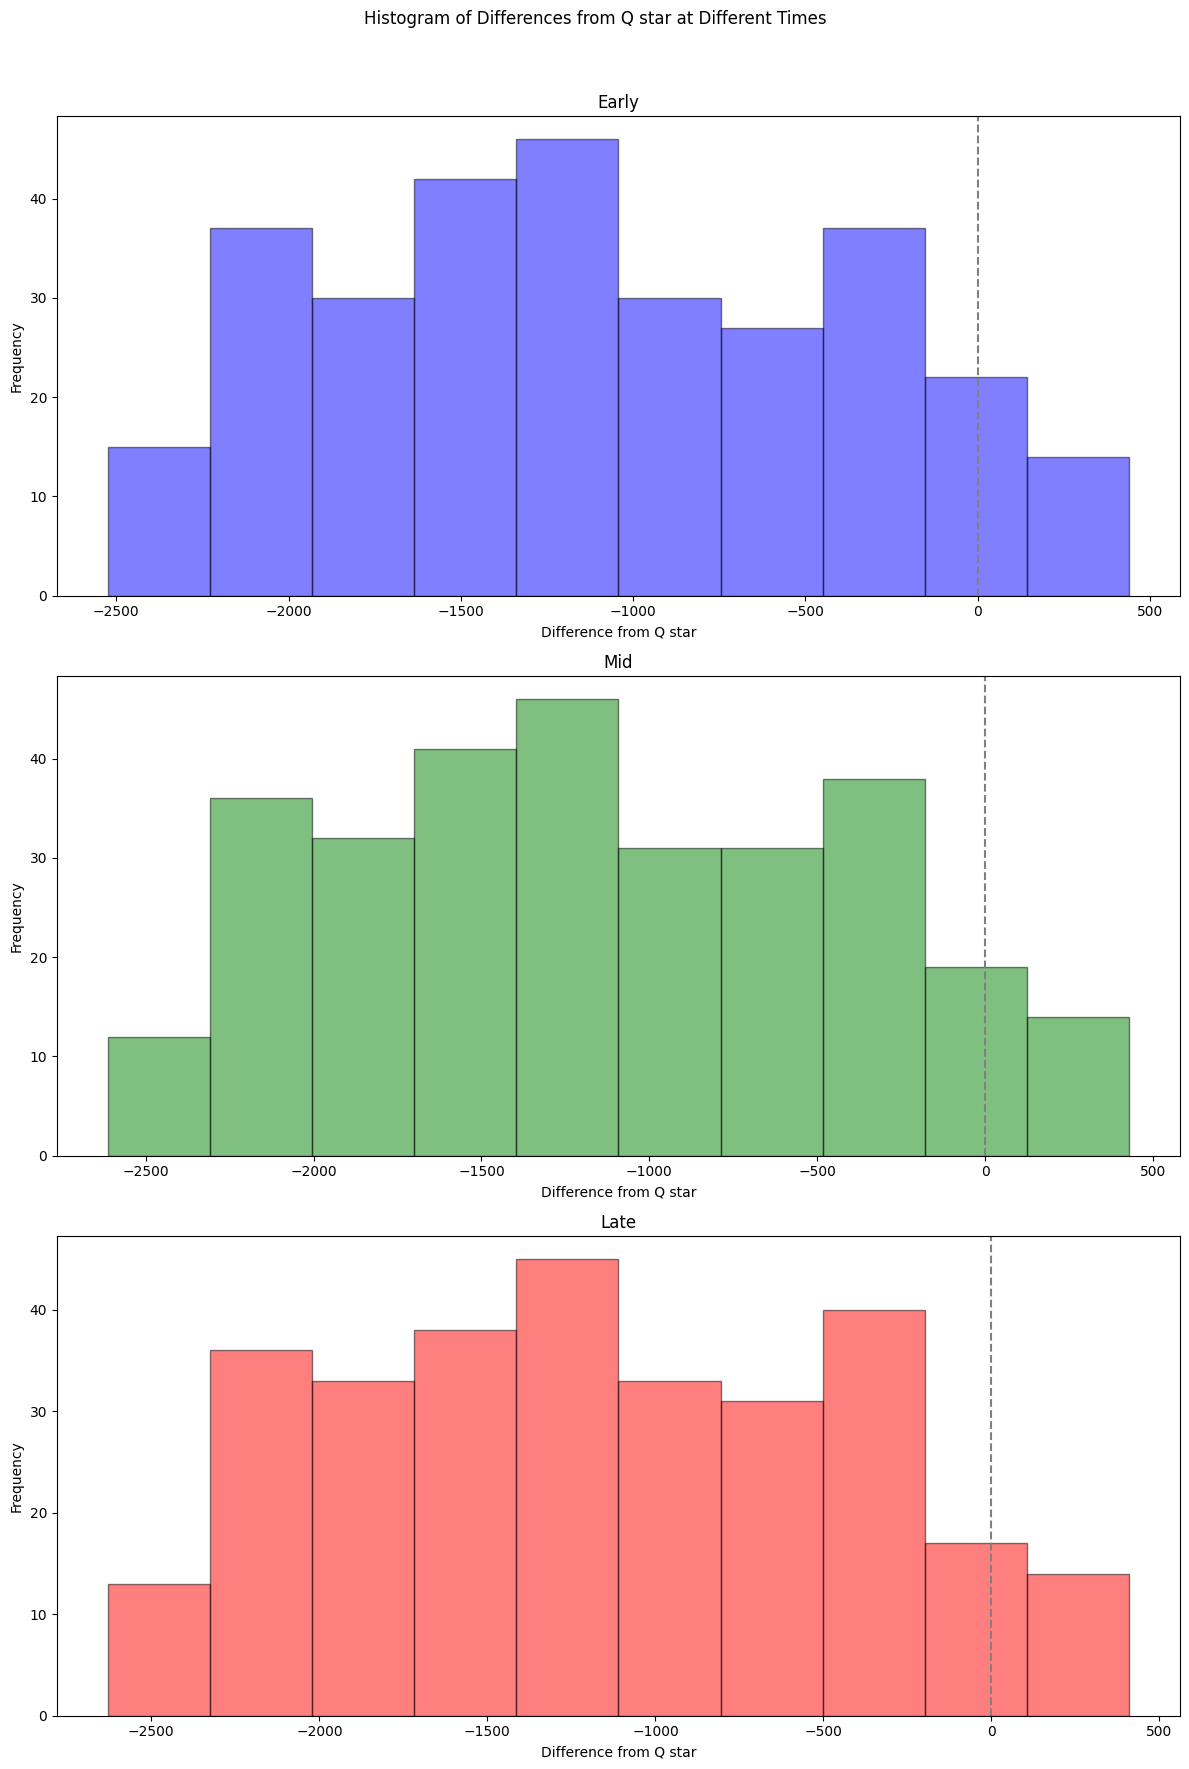

In [43]:
# 繪製直方圖
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 早期
axes[0].hist(early_diff, bins=10, alpha=0.5, color="blue", edgecolor="black")
axes[0].axvline(0, color="grey", linestyle="--")
axes[0].set_title("Early")
axes[0].set_xlabel("Difference from Q star")
axes[0].set_ylabel("Frequency")

# 中期
axes[1].hist(mid_diff, bins=10, alpha=0.5, color="green", edgecolor="black")
axes[1].axvline(0, color="grey", linestyle="--")
axes[1].set_title("Mid")
axes[1].set_xlabel("Difference from Q star")
axes[1].set_ylabel("Frequency")

# 晚期
axes[2].hist(late_diff, bins=10, alpha=0.5, color="red", edgecolor="black")
axes[2].axvline(0, color="grey", linestyle="--")
axes[2].set_title("Late")
axes[2].set_xlabel("Difference from Q star")
axes[2].set_ylabel("Frequency")

fig.suptitle("Histogram of Differences from Q star at Different Times")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()